Загруженные колонки: ['author', 'author_type', 'url', 'location', 'deal_type', 'accommodation_type', 'floor', 'floors_count', 'rooms_count', 'total_meters', 'price_per_month', 'commissions', 'price', 'district', 'street', 'house_number', 'underground', 'residential_complex']


Введите значение ставки Банка России (в %):  18
Введите процент инфляции (в %):  14


Пример скорректированных данных:
     price  adjusted_price
0  23870.7     32110.86564
1  79000.0    106270.80000
2  78800.0    106001.76000
3  21519.6     28948.16592
4   9000.0     12106.80000


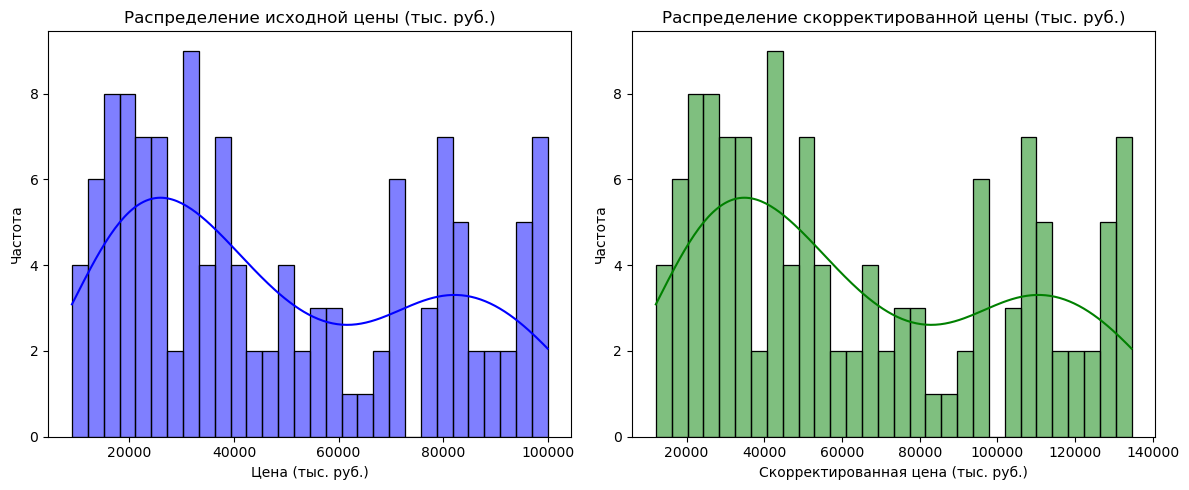

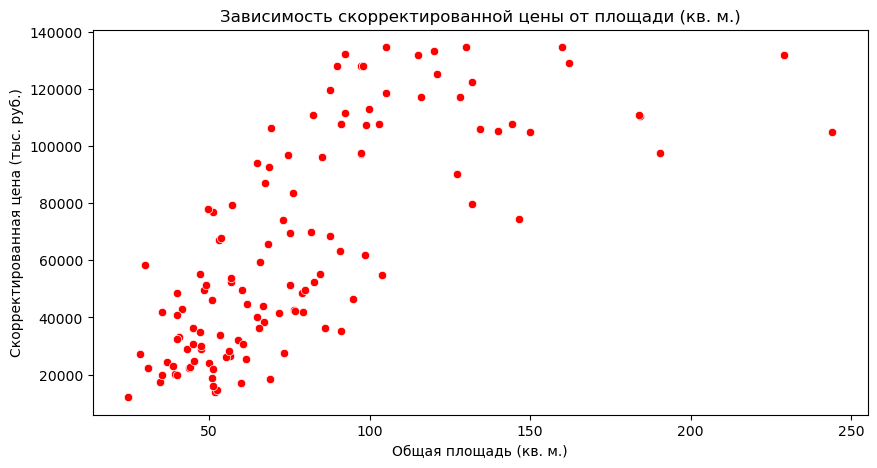


Метрики модели на тестовых данных:
MSE: 494864611.754942
R²: 0.714603
MAE: 17894.189375


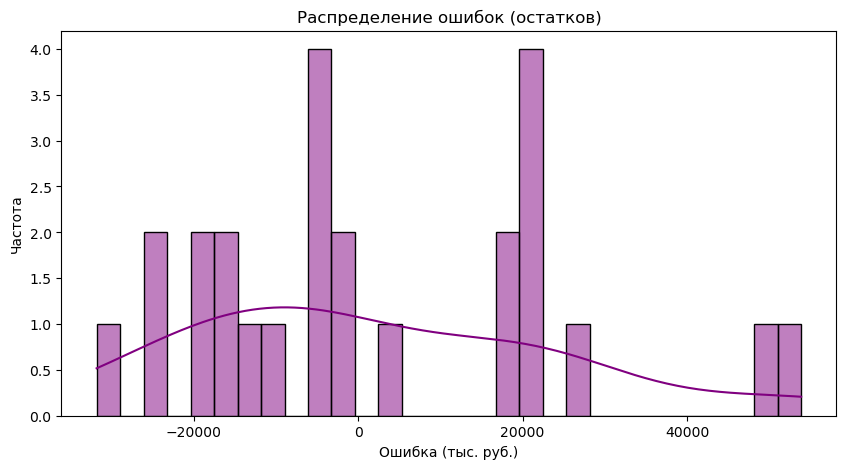

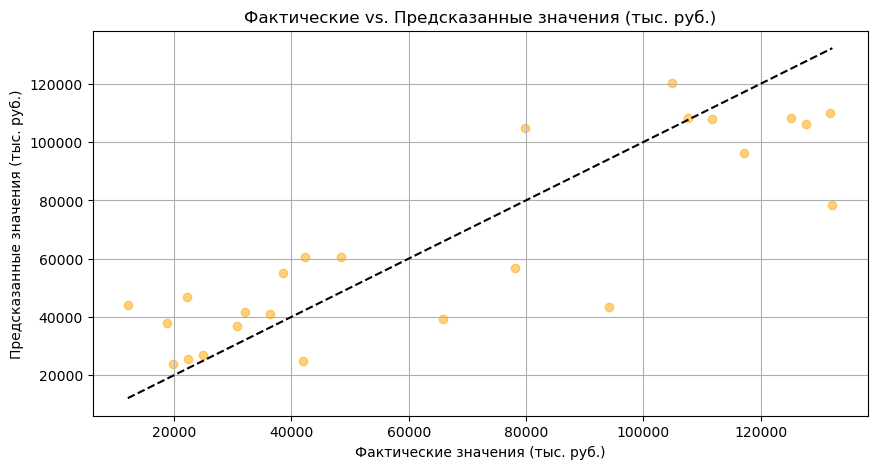

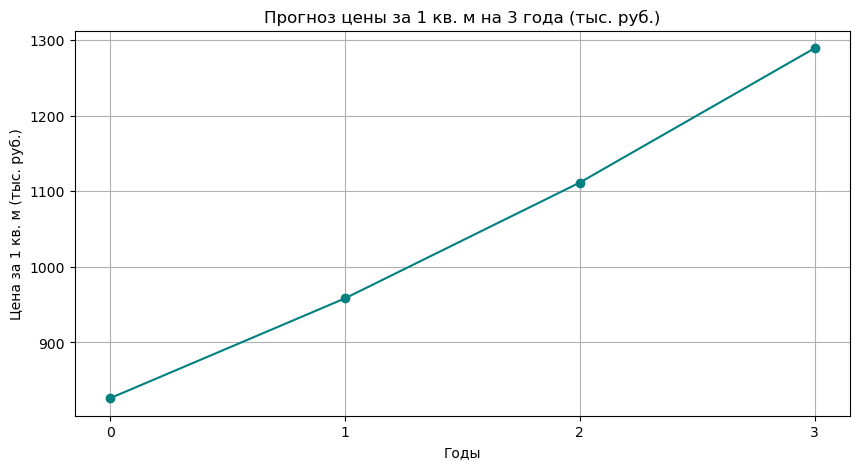

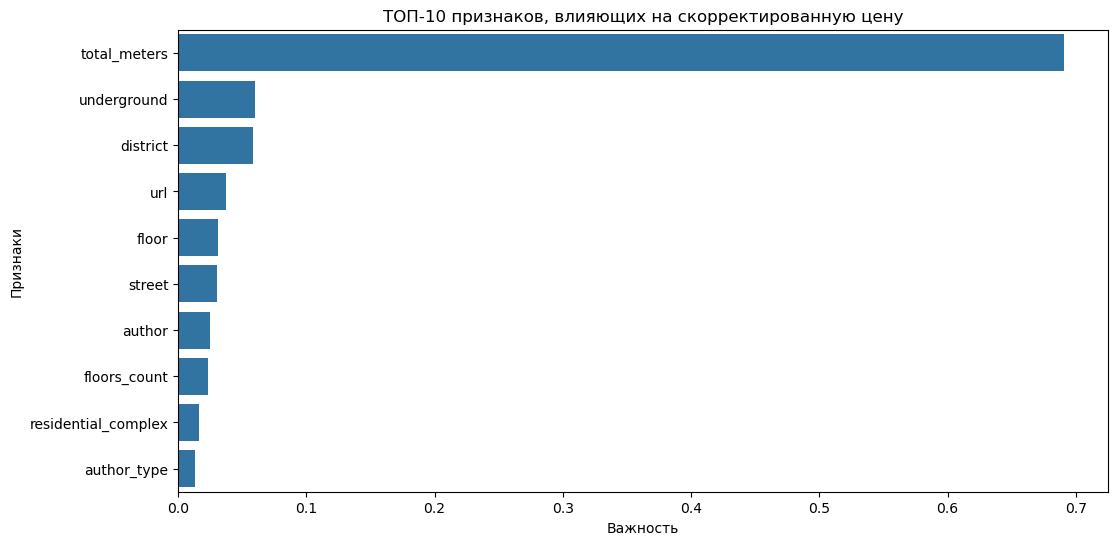

In [30]:
# Улучшеная модель градиентного бустинга

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder

# Функция для валидации ввода
def validate_input(prompt, min_value=None, max_value=None):
    while True:
        try:
            value = float(input(prompt).replace(",", "."))
            if min_value is not None and value < min_value:
                print(f"Значение должно быть не меньше {min_value}.")
                continue
            if max_value is not None and value > max_value:
                print(f"Значение должно быть не больше {max_value}.")
                continue
            return value
        except ValueError:
            print("Ошибка: Введите корректное число.")

# Загрузка данных
file_path = '/Users/ilyalevshenkov/_GB/GB_Diplom/Sale/Москва_sale_filtered_data.csv'
data = pd.read_csv(file_path)
print(f"Загруженные колонки: {list(data.columns)}")

# Ввод ставки Банка России и процента инфляции с валидацией
bank_rate = validate_input("Введите значение ставки Банка России (в %): ", min_value=0, max_value=100)
inflation_rate = validate_input("Введите процент инфляции (в %): ", min_value=0, max_value=100)

# Обработка данных: корректировка цены на основе ставки банка и инфляции
data['adjusted_price'] = data['price'] * (1 + bank_rate / 100) * (1 + inflation_rate / 100)

# Приведение всех цен к тысячам рублей
data['price'] = data['price'] / 1000  # Приведение цены к тыс. руб.
data['adjusted_price'] = data['adjusted_price'] / 1000  # Приведение скорректированной цены к тыс. руб.

# Вывод скорректированных данных
print("Пример скорректированных данных:")
print(data[['price', 'adjusted_price']].head())

# Визуализация распределения цен до и после корректировки
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(data['price'], kde=True, color='blue', bins=30)
plt.title("Распределение исходной цены (тыс. руб.)")
plt.xlabel("Цена (тыс. руб.)")
plt.ylabel("Частота")

plt.subplot(1, 2, 2)
sns.histplot(data['adjusted_price'], kde=True, color='green', bins=30)
plt.title("Распределение скорректированной цены (тыс. руб.)")
plt.xlabel("Скорректированная цена (тыс. руб.)")
plt.ylabel("Частота")
plt.tight_layout()
plt.show()

# Визуализация зависимости цены от нескольких признаков
plt.figure(figsize=(10, 5))
sns.scatterplot(x=data['total_meters'], y=data['adjusted_price'], color='red')
plt.title("Зависимость скорректированной цены от площади (кв. м.)")
plt.xlabel("Общая площадь (кв. м.)")
plt.ylabel("Скорректированная цена (тыс. руб.)")
plt.show()

# Обработка категориальных данных
label_encoder = LabelEncoder()
categorical_columns = data.select_dtypes(include=['object']).columns

# Применяем LabelEncoder к каждой категориальной колонке
for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col].astype(str))

# Предобработка данных
X = data.drop(['price', 'adjusted_price'], axis=1)  # Убираем цену и скорректированную цену из признаков
y = data['adjusted_price']  # Целевая переменная — скорректированная цена

# Разделение данных на тренировочные и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Оптимизация модели через кросс-валидацию (пример с настройками гиперпараметров)
best_params = {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
model = GradientBoostingRegressor(**best_params)
model.fit(X_train, y_train)

# Прогнозирование и оценка модели
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# Вывод метрик модели
print(f"\nМетрики модели на тестовых данных:")
print(f"MSE: {mse:.6f}")
print(f"R²: {r2:.6f}")
print(f"MAE: {mae:.6f}")

# Визуализация распределения ошибок модели
plt.figure(figsize=(10, 5))
sns.histplot(y_test - y_pred, kde=True, color='purple', bins=30)
plt.title("Распределение ошибок (остатков)")
plt.xlabel("Ошибка (тыс. руб.)")
plt.ylabel("Частота")
plt.show()

# Визуализация фактических и предсказанных значений
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred, alpha=0.5, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='black')
plt.title("Фактические vs. Предсказанные значения (тыс. руб.)")
plt.xlabel("Фактические значения (тыс. руб.)")
plt.ylabel("Предсказанные значения (тыс. руб.)")
plt.grid()
plt.show()

# Прогноз цены за 1 кв. м на три года
# Используем текущее время, если дата не доступна
current_date = pd.to_datetime('today')  
years = [0, 1, 2, 3]
predicted_prices_per_sqm = []

# Простой линейный рост цен
price_growth_rate = (inflation_rate + bank_rate) / 2 / 100  # Предполагаем, что это средний рост
initial_price_per_sqm = data['adjusted_price'].mean() / data['total_meters'].mean()  # Начальная цена за 1 кв. м.

for year in years:
    predicted_price = initial_price_per_sqm * (1 + price_growth_rate) ** year
    predicted_prices_per_sqm.append(predicted_price)

# Визуализация прогноза цены за 1 кв. м на 3 года
plt.figure(figsize=(10, 5))
plt.plot(years, predicted_prices_per_sqm, marker='o', color='teal', linestyle='-')
plt.title("Прогноз цены за 1 кв. м на 3 года (тыс. руб.)")
plt.xlabel("Годы")
plt.ylabel("Цена за 1 кв. м (тыс. руб.)")
plt.xticks(years)
plt.grid()
plt.show()

# ТОП-10 признаков, влияющих на цену
feature_importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
top_features = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Визуализация ТОП-10 признаков
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title("ТОП-10 признаков, влияющих на скорректированную цену")
plt.xlabel("Важность")
plt.ylabel("Признаки")
plt.show()
